<h1 align='center'> Segmentação de Clientes de um Atacado por Perfil de Compra </h1>

In [44]:
library(IRdisplay)

display_html(
"<script>
code_show=true; function code_toggle() { 
   if (code_show){ $('div.input').hide(); 
   } else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle); 
</script>

<br>Clique <a href='javascript:code_toggle()'>aqui</a> para mostrar o código.")

Clique aqui para mostrar o código.

In [6]:
oldw <- getOption("warn")
options(warn = -1)

library(dplyr)
library(data.table)
library(tidyr)
library(ggplot2)
library(stringr)
library(factoextra)
library(FactoMineR)
library(ggthemes)

options(warn = oldw)

<h3>Objetivo e Dados</h3>

O objetivo desta aplicação é criar segmentos de clientes de um Distribuidor por Atacado com aprendizagem não supervisionada, com base no perfil de compra dos clientes. A linguagem utilizada foi o R.

A <a href='https://archive.ics.uci.edu/ml/datasets/wholesale+customers'>base utilizada</a> é clássica em aplicações do tipo. Em termos gerais, cada observação mostra o gasto total por categoria de produtos de cada cliente em unidades monetárias. Os segmentos são Produtos Frescos, Laticínios, Mercearia, Congelados, Higiene e Iguarias, como mostra a tabela abaixo.

In [7]:
df <- fread("customers.csv", sep=',')
df <- subset(df, select = -c(Channel, Region))
log_df <- log(df)

head(df)
# Fitando modelo de K-Means
#fviz_nbclust(log_df, kmeans, method = "silhouette")
k2 <- kmeans(log_df, centers = 2, nstart = 25)


result <- data.frame(k2$cluster)
df$ind <- seq.int(nrow(df))
log_df$ind <- seq.int(nrow(log_df))
result$ind <- seq.int(nrow(result))

log_df <- merge(log_df, result, by='ind')
log_df <- subset(log_df, select=-c(ind))

df <- merge(df, result, by='ind')
df <- subset(df, select=-c(ind))


df_pca <- PCA(log_df[,-7], graph=F)

log_df$k2.cluster <- ifelse(log_df$k2.cluster==1,"Perfil 1", "Perfil 2")
df$k2.cluster <- ifelse(df$k2.cluster==1,"Perfil 1", "Perfil 2")

df_sum <- aggregate(.~k2.cluster, df, mean)
df_sum <- melt(df_sum, id.var=c('k2.cluster'))
df_sum$value <- round(df_sum$value/100)

Frescos,Laticinios,Mercearia,Congelados,Higiene,Iguarias
<int>,<int>,<int>,<int>,<int>,<int>
12669,9656,7561,214,2674,1338
7057,9810,9568,1762,3293,1776
6353,8808,7684,2405,3516,7844
13265,1196,4221,6404,507,1788
22615,5410,7198,3915,1777,5185
9413,8259,5126,666,1795,1451


<h3>Resultados Gráficos</h3>

O PCA <a href='http://setosa.io/ev/principal-component-analysis/'>(Principal Component Analysis)</a> é um modo de reduzir a quantidade de dimensões de um base de dados. Nesta aplicação, o método foi utilizado apenas para visualização, monstrando no gráfico abaixo as 6 variáveis da em uma plotagem bidimensional.

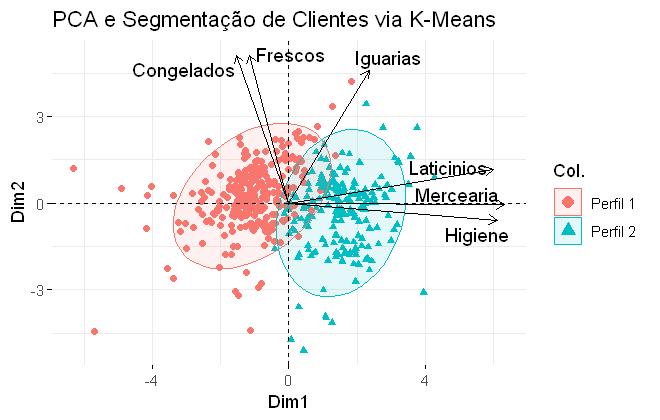

In [46]:
options(repr.plot.width=5.5, repr.plot.height=3.5)

fviz_pca_biplot(df_pca, col.ind = df$k2.cluster,
                label = "var",
                col.var = "black", repel = TRUE,
                addEllipses=TRUE, ellipse.level=0.90) +
  labs(title ="PCA e Segmentação de Clientes via K-Means" ,x="Dim1", y="Dim2")

Os perfis de compra de dos clientes foram definidos pelo <a href='https://scikit-learn.org/stable/modules/neighbors.html'>modelo KNN</a>, que analisa as observações mais próximas entre si para criar segmentações, neste caso, de clientes.

Os testes feitos (e suprimidos nesta analise) indicaram 2 perfis principais de clientes, mostrados no gráfico acima. Fica bem evidente que os clientes de Perfil 1 estão mais para o lado esquerdo do gráfico, onde há maior gasto com produtos congelados e frescos em relação ao perfil 2, enquanto o segundo perfil, no lado direito do gráfico, indica maior compra dos outros segmentos, como laticínios, mercearia, higiene e iguarias.

Para analisar esses gastos de forma mais especifica, o gráfico de barra abaixo mostra o valor gasto por perfil e tipo de porduto. De fato, o perfil 1 gasta mais com produtos congelados e frescos, enquanto o outros perfil, gasta mais com mercearia e laticínios.

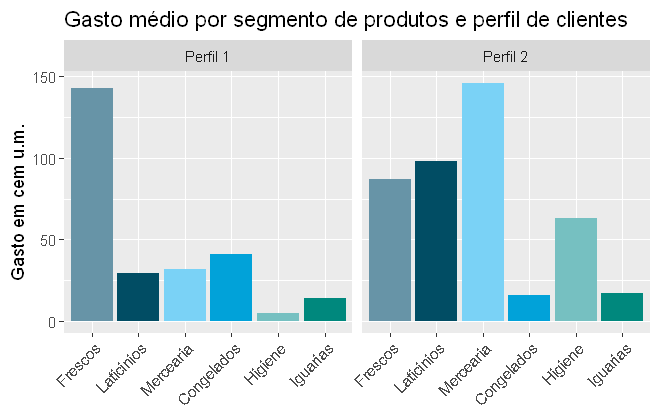

In [35]:
ggplot(data=df_sum, aes(x=variable, y=value, fill=variable)) + 
  geom_bar(stat="identity") + scale_fill_economist() +
  facet_grid(~k2.cluster) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  labs(title ="Gasto médio por segmento de produtos e perfil de clientes ", y = "Gasto em cem u.m.", x = NULL)

Apesar de poderosas, aplicações de machine learning não são mágica. O foco do modelo é entregar as relações entre os dados, mas ainda não tem capacidade de interpretar o significado.

O perfil 1 e 2 indicados pelo modelo podem ser clientes varejistas e restaurantes ou bares, mas este entendimento parte de pessoas com profundo conhecimento do negócio para poder validar os resultados e gerar insights.